In [68]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Data Path
dataPath = "../../Data/Toxic-Thread-Detector/jigsaw-toxic"
train = pd.read_csv(dataPath + "/train.csv")
test = pd.read_csv(dataPath + "/test.csv")

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xil14\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


Using TensorFlow backend.


In [57]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../../Data/Toxic-Thread-Detector/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [16]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [18]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [19]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
comments_train = train['comment_text']
comments_test = test['comment_text']

In [21]:
comments_train = list(comments_train)

In [31]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [32]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

In [41]:
print('Sample data:', texts[0], y[0])

Sample data: xplanationwhy edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired now892053 [0 0 0 0 0 0]


In [34]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [35]:
tokenizer.fit_on_texts(texts)

In [38]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [42]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [52]:
# random shuffle the entries
np.random.seed(1) 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [53]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [54]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12331  1299  6787   381  6361  1130]
validation:  [2963  296 1662   97 1516  275]


In [55]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [49029   493 84901   856   791    35    58   506  2797   125  1322   425
     3  1341  1620   103  4917  5435    57    13  1872    26  5768   632
  1614   535 31789  3401   339  1831    57 27798     4   108  1196  9906
  1827     7    13  1403   365   791   506  1960  5165    12    27   161
  3997   382   651   118  5435  1247    36  2189   173    43    15     3
   411     6     6   411    21  1011    63   189   536   992    12    58
   165    34 84902   110  5435   661    55     3   103  3011  4223   621
   661   444   809  1247    42   809  7061  7404  5564  1041    21  1247
 14079   202  5435    81  1872   502  5435    62   202   155   259   158
   244  4885  7707    92   238  1247 14990  1663    62  2145  2234   305
  1580    85   182    84   703  7345    79   113   621    81    84  6968
  1768   155   259  7920    57    16  2532  3591    31  5564  1638   320
     3  8630    97    14   375  1057   148  3395    46 63550     8   565
 63551  6217    14  1710   6

In [61]:
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: ../../Data/Toxic-Thread-Detector/glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [62]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [123]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="softmax")(x)

In [124]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [125]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Train on 127657 samples, validate on 31914 samples
Epoch 1/2


  5632/127657 [>.............................] - ETA: 2:09:18 - loss: 0.2500 - accuracy: 0.958 - ETA: 1:10:15 - loss: 0.2414 - accuracy: 0.963 - ETA: 50:33 - loss: 0.2274 - accuracy: 0.9722  - ETA: 41:43 - loss: 0.2236 - accuracy: 0.974 - ETA: 35:52 - loss: 0.2216 - accuracy: 0.975 - ETA: 31:51 - loss: 0.2241 - accuracy: 0.973 - ETA: 28:51 - loss: 0.2245 - accuracy: 0.972 - ETA: 26:30 - loss: 0.2338 - accuracy: 0.966 - ETA: 24:39 - loss: 0.2332 - accuracy: 0.966 - ETA: 23:08 - loss: 0.2309 - accuracy: 0.967 - ETA: 21:54 - loss: 0.2313 - accuracy: 0.967 - ETA: 20:51 - loss: 0.2321 - accuracy: 0.966 - ETA: 19:56 - loss: 0.2290 - accuracy: 0.968 - ETA: 19:11 - loss: 0.2285 - accuracy: 0.969 - ETA: 18:30 - loss: 0.2273 - accuracy: 0.969 - ETA: 17:56 - loss: 0.2317 - accuracy: 0.966 - ETA: 17:26 - loss: 0.2318 - accuracy: 0.966 - ETA: 16:59 - loss: 0.2298 - accuracy: 0.967 - ETA: 16:36 - loss: 0.2279 - accuracy: 0.968 - ETA: 16:14 - loss: 0.2270 - accuracy: 0.969 - ETA: 15:53 - loss: 0.2308

 11520/127657 [=>............................] - ETA: 10:15 - loss: 0.2320 - accuracy: 0.964 - ETA: 10:14 - loss: 0.2320 - accuracy: 0.964 - ETA: 10:14 - loss: 0.2318 - accuracy: 0.964 - ETA: 10:13 - loss: 0.2321 - accuracy: 0.963 - ETA: 10:12 - loss: 0.2322 - accuracy: 0.963 - ETA: 10:12 - loss: 0.2323 - accuracy: 0.963 - ETA: 10:11 - loss: 0.2321 - accuracy: 0.963 - ETA: 10:11 - loss: 0.2321 - accuracy: 0.963 - ETA: 10:10 - loss: 0.2321 - accuracy: 0.963 - ETA: 10:10 - loss: 0.2320 - accuracy: 0.963 - ETA: 10:09 - loss: 0.2320 - accuracy: 0.964 - ETA: 10:09 - loss: 0.2318 - accuracy: 0.964 - ETA: 10:08 - loss: 0.2318 - accuracy: 0.964 - ETA: 10:08 - loss: 0.2317 - accuracy: 0.964 - ETA: 10:07 - loss: 0.2319 - accuracy: 0.964 - ETA: 10:06 - loss: 0.2319 - accuracy: 0.964 - ETA: 10:06 - loss: 0.2318 - accuracy: 0.964 - ETA: 10:05 - loss: 0.2319 - accuracy: 0.964 - ETA: 10:05 - loss: 0.2318 - accuracy: 0.964 - ETA: 10:04 - loss: 0.2322 - accuracy: 0.963 - ETA: 10:04 - loss: 0.2320 - acc

 17472/127657 [===>..........................] - ETA: 9:10 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:10 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:09 - loss: 0.2335 - accuracy: 0.96 - ETA: 9:09 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:09 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:09 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:09 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:08 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:08 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:08 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:08 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:07 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:07 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:07 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:07 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:06 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:06 - loss: 0.2337 - accuracy: 0.96 - ETA: 9:06 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:06 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:05 - loss: 0.2336 - accuracy: 0.96 - ETA: 9:05 - loss: 0.2338 - accuracy: 0.96 - ETA: 9:05 - loss: 0.2337 - 

 23424/127657 [====>.........................] - ETA: 8:30 - loss: 0.2329 - accuracy: 0.96 - ETA: 8:30 - loss: 0.2329 - accuracy: 0.96 - ETA: 8:30 - loss: 0.2331 - accuracy: 0.96 - ETA: 8:30 - loss: 0.2330 - accuracy: 0.96 - ETA: 8:29 - loss: 0.2330 - accuracy: 0.96 - ETA: 8:29 - loss: 0.2331 - accuracy: 0.96 - ETA: 8:29 - loss: 0.2330 - accuracy: 0.96 - ETA: 8:29 - loss: 0.2331 - accuracy: 0.96 - ETA: 8:29 - loss: 0.2330 - accuracy: 0.96 - ETA: 8:28 - loss: 0.2331 - accuracy: 0.96 - ETA: 8:28 - loss: 0.2331 - accuracy: 0.96 - ETA: 8:28 - loss: 0.2332 - accuracy: 0.96 - ETA: 8:28 - loss: 0.2332 - accuracy: 0.96 - ETA: 8:28 - loss: 0.2333 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2333 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2334 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2334 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2333 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2333 - accuracy: 0.96 - ETA: 8:27 - loss: 0.2333 - accuracy: 0.96 - ETA: 8:26 - loss: 0.2334 - accuracy: 0.96 - ETA: 8:26 - loss: 0.2333 - 

 29376/127657 [=====>........................] - ETA: 7:57 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:57 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:57 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 7:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 7:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 7:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:55 - loss: 0.2324 - accuracy: 0.96 - ETA: 7:54 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:54 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:54 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:54 - loss: 0.2325 - 

 35328/127657 [=======>......................] - ETA: 7:27 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:27 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:27 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:27 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:27 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2326 - accuracy: 0.96 - ETA: 7:26 - loss: 0.2327 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2326 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2326 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2326 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2326 - accuracy: 0.96 - ETA: 7:25 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:24 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:24 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:24 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:24 - loss: 0.2325 - accuracy: 0.96 - ETA: 7:24 - loss: 0.2324 - 

 41280/127657 [========>.....................] - ETA: 6:58 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:58 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:58 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:58 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:58 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:57 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:56 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:55 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:55 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:55 - loss: 0.2324 - 

 47232/127657 [==========>...................] - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:30 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:29 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:28 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:27 - loss: 0.2322 - accuracy: 0.96 - ETA: 6:27 - loss: 0.2322 - 

 53184/127657 [===========>..................] - ETA: 6:03 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:03 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:02 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:01 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2324 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2323 - accuracy: 0.96 - ETA: 6:00 - loss: 0.2323 - 

 59136/127657 [============>.................] - ETA: 5:35 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:35 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:35 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:35 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:35 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2324 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2324 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2324 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:34 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2324 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:33 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:32 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:32 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:32 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:32 - loss: 0.2325 - 

 65088/127657 [==============>...............] - ETA: 5:08 - loss: 0.2327 - accuracy: 0.96 - ETA: 5:08 - loss: 0.2327 - accuracy: 0.96 - ETA: 5:08 - loss: 0.2327 - accuracy: 0.96 - ETA: 5:08 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:08 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:08 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2326 - accuracy: 0.96 - ETA: 5:07 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:06 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:05 - loss: 0.2325 - accuracy: 0.96 - ETA: 5:05 - loss: 0.2325 - 

 71040/127657 [===============>..............] - ETA: 4:41 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:41 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:41 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:41 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:41 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:40 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:39 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:38 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:38 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:38 - loss: 0.2322 - 

 76992/127657 [=================>............] - ETA: 4:14 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:14 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:14 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:14 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:14 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:13 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:12 - loss: 0.2322 - accuracy: 0.96 - ETA: 4:11 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:11 - loss: 0.2323 - accuracy: 0.96 - ETA: 4:11 - loss: 0.2322 - 

 82944/127657 [==================>...........] - ETA: 3:47 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:47 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:47 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:47 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:47 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:46 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:45 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:44 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:44 - loss: 0.2320 - accuracy: 0.96 - ETA: 3:44 - loss: 0.2320 - 

 88896/127657 [===================>..........] - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 3:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2318 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2318 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:18 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:17 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:17 - loss: 0.2318 - 

 94848/127657 [=====================>........] - ETA: 2:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 2:54 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:53 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:52 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2320 - accuracy: 0.96 - ETA: 2:51 - loss: 0.2319 - 

100800/127657 [======================>.......] - ETA: 2:27 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:27 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:27 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:26 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:25 - loss: 0.2318 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - accuracy: 0.96 - ETA: 2:24 - loss: 0.2317 - 

106752/127657 [========================>.....] - ETA: 2:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 2:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 2:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 2:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:59 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:58 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:57 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:57 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:57 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:57 - loss: 0.2316 - 

112704/127657 [=========================>....] - ETA: 1:33 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:33 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:33 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:33 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:33 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:32 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:31 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:30 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:30 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:30 - loss: 0.2318 - 

118656/127657 [==========================>...] - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:06 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:05 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2319 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2319 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2319 - accuracy: 0.96 - ETA: 1:04 - loss: 0.2318 - accuracy: 0.96 - ETA: 1:03 - loss: 0.2318 - 

124608/127657 [============================>.] - ETA: 40s - loss: 0.2318 - accuracy: 0.963 - ETA: 40s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 39s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 38s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - accuracy: 0.963 - ETA: 37s - loss: 0.2318 - a

127657/127657 [==============================] - ETA: 13s - loss: 0.2319 - accuracy: 0.963 - ETA: 13s - loss: 0.2319 - accuracy: 0.963 - ETA: 13s - loss: 0.2319 - accuracy: 0.963 - ETA: 13s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 12s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2319 - accuracy: 0.963 - ETA: 11s - loss: 0.2318 - accuracy: 0.963 - ETA: 10s - loss: 0.2318 - accuracy: 0.963 - ETA: 10s - loss: 0.2318 - accuracy: 0.963 - ETA: 10s - loss: 0.2318 - accuracy: 0.963 - ETA: 10s - loss: 0.2319 - a

  5760/127657 [>.............................] - ETA: 10:48 - loss: 0.2037 - accuracy: 0.984 - ETA: 10:26 - loss: 0.2150 - accuracy: 0.976 - ETA: 10:12 - loss: 0.2108 - accuracy: 0.979 - ETA: 10:13 - loss: 0.2072 - accuracy: 0.981 - ETA: 10:25 - loss: 0.2193 - accuracy: 0.972 - ETA: 10:18 - loss: 0.2216 - accuracy: 0.971 - ETA: 10:12 - loss: 0.2247 - accuracy: 0.968 - ETA: 10:20 - loss: 0.2242 - accuracy: 0.968 - ETA: 11:23 - loss: 0.2256 - accuracy: 0.967 - ETA: 11:41 - loss: 0.2227 - accuracy: 0.969 - ETA: 11:31 - loss: 0.2215 - accuracy: 0.970 - ETA: 11:23 - loss: 0.2247 - accuracy: 0.967 - ETA: 11:15 - loss: 0.2240 - accuracy: 0.967 - ETA: 11:37 - loss: 0.2246 - accuracy: 0.967 - ETA: 11:34 - loss: 0.2256 - accuracy: 0.967 - ETA: 11:32 - loss: 0.2242 - accuracy: 0.968 - ETA: 11:38 - loss: 0.2246 - accuracy: 0.968 - ETA: 11:29 - loss: 0.2276 - accuracy: 0.965 - ETA: 11:22 - loss: 0.2271 - accuracy: 0.966 - ETA: 11:15 - loss: 0.2294 - accuracy: 0.964 - ETA: 11:10 - loss: 0.2321 - acc

 11712/127657 [=>............................] - ETA: 9:26 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:26 - loss: 0.2332 - accuracy: 0.96 - ETA: 9:25 - loss: 0.2333 - accuracy: 0.96 - ETA: 9:25 - loss: 0.2334 - accuracy: 0.96 - ETA: 9:25 - loss: 0.2333 - accuracy: 0.96 - ETA: 9:24 - loss: 0.2332 - accuracy: 0.96 - ETA: 9:24 - loss: 0.2332 - accuracy: 0.96 - ETA: 9:23 - loss: 0.2333 - accuracy: 0.96 - ETA: 9:23 - loss: 0.2333 - accuracy: 0.96 - ETA: 9:23 - loss: 0.2331 - accuracy: 0.96 - ETA: 9:22 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:22 - loss: 0.2331 - accuracy: 0.96 - ETA: 9:21 - loss: 0.2329 - accuracy: 0.96 - ETA: 9:21 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:21 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:20 - loss: 0.2331 - accuracy: 0.96 - ETA: 9:20 - loss: 0.2333 - accuracy: 0.96 - ETA: 9:20 - loss: 0.2331 - accuracy: 0.96 - ETA: 9:19 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:19 - loss: 0.2328 - accuracy: 0.96 - ETA: 9:19 - loss: 0.2330 - accuracy: 0.96 - ETA: 9:18 - loss: 0.2329 - 

 17664/127657 [===>..........................] - ETA: 8:37 - loss: 0.2316 - accuracy: 0.96 - ETA: 8:37 - loss: 0.2315 - accuracy: 0.96 - ETA: 8:37 - loss: 0.2315 - accuracy: 0.96 - ETA: 8:37 - loss: 0.2316 - accuracy: 0.96 - ETA: 8:36 - loss: 0.2315 - accuracy: 0.96 - ETA: 8:36 - loss: 0.2315 - accuracy: 0.96 - ETA: 8:36 - loss: 0.2314 - accuracy: 0.96 - ETA: 8:36 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:36 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:35 - loss: 0.2312 - accuracy: 0.96 - ETA: 8:35 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:35 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:35 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:35 - loss: 0.2314 - accuracy: 0.96 - ETA: 8:34 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:34 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:34 - loss: 0.2312 - accuracy: 0.96 - ETA: 8:34 - loss: 0.2313 - accuracy: 0.96 - ETA: 8:34 - loss: 0.2314 - accuracy: 0.96 - ETA: 8:33 - loss: 0.2314 - accuracy: 0.96 - ETA: 8:33 - loss: 0.2316 - accuracy: 0.96 - ETA: 8:33 - loss: 0.2316 - 

 23616/127657 [====>.........................] - ETA: 8:04 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:04 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:04 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:04 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:04 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2307 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2307 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:03 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2308 - accuracy: 0.96 - ETA: 8:02 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:01 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:01 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:01 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:01 - loss: 0.2309 - accuracy: 0.96 - ETA: 8:01 - loss: 0.2308 - 

 29568/127657 [=====>........................] - ETA: 7:35 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:35 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:35 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2312 - accuracy: 0.96 - ETA: 7:34 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2310 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:33 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2310 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2311 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2310 - accuracy: 0.96 - ETA: 7:32 - loss: 0.2310 - 

 35520/127657 [=======>......................] - ETA: 7:07 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:07 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:07 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:07 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:07 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2314 - accuracy: 0.96 - ETA: 7:06 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:05 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:04 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:04 - loss: 0.2315 - accuracy: 0.96 - ETA: 7:04 - loss: 0.2315 - 

 41472/127657 [========>.....................] - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:40 - loss: 0.2316 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:37 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:37 - loss: 0.2314 - 

 47424/127657 [==========>...................] - ETA: 6:14 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:14 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:13 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:12 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2314 - accuracy: 0.96 - ETA: 6:11 - loss: 0.2315 - 

 53376/127657 [===========>..................] - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2319 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2319 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2319 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2318 - 

 59328/127657 [============>.................] - ETA: 5:21 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:21 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:21 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:21 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2317 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:20 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:19 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:18 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:18 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:18 - loss: 0.2318 - accuracy: 0.96 - ETA: 5:18 - loss: 0.2318 - 

 65280/127657 [==============>...............] - ETA: 4:55 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2319 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2318 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2318 - 

 71232/127657 [===============>..............] - ETA: 4:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:26 - loss: 0.2316 - 

 77184/127657 [=================>............] - ETA: 4:03 - loss: 0.2317 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2317 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2317 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2317 - 

 83136/127657 [==================>...........] - ETA: 3:37 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:37 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:37 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:37 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:37 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:37 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:36 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2317 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:35 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:34 - loss: 0.2316 - accuracy: 0.96 - ETA: 3:34 - loss: 0.2316 - 

 89088/127657 [===================>..........] - ETA: 3:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2315 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2314 - 

 95040/127657 [=====================>........] - ETA: 2:46 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:46 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:45 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2312 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:44 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:43 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:43 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:43 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:43 - loss: 0.2313 - accuracy: 0.96 - ETA: 2:43 - loss: 0.2313 - 

100992/127657 [======================>.......] - ETA: 2:20 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2316 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2315 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2316 - 

106944/127657 [========================>.....] - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:54 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:53 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:52 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:51 - loss: 0.2317 - 

112896/127657 [=========================>....] - ETA: 1:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:29 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2317 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2316 - 

118848/127657 [==========================>...] - ETA: 1:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:03 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:02 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:01 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:00 - loss: 0.2316 - accuracy: 0.96 - ETA: 1:00 - loss: 0.2316 - 

124800/127657 [============================>.] - ETA: 37s - loss: 0.2316 - accuracy: 0.963 - ETA: 37s - loss: 0.2316 - accuracy: 0.963 - ETA: 37s - loss: 0.2316 - accuracy: 0.963 - ETA: 37s - loss: 0.2315 - accuracy: 0.963 - ETA: 37s - loss: 0.2315 - accuracy: 0.963 - ETA: 37s - loss: 0.2315 - accuracy: 0.963 - ETA: 37s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 36s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 35s - loss: 0.2315 - accuracy: 0.963 - ETA: 34s - loss: 0.2315 - a

127657/127657 [==============================] - ETA: 12s - loss: 0.2315 - accuracy: 0.963 - ETA: 12s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 11s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 10s - loss: 0.2315 - accuracy: 0.963 - ETA: 9s - loss: 0.2315 - accuracy: 0.963 - ETA: 9s - loss: 0.2315 - accuracy: 0.96 - ETA: 9s - loss: 0.2315 - accuracy: 0.96 - ETA: 9s - loss: 0.2315 - accuracy: 0.96 - ETA: 9s - loss: 0.2315 - accuracy: 0.96 - ETA: 9s - loss: 0.2315 - accuracy: 0

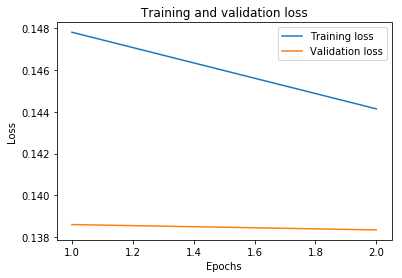

In [69]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

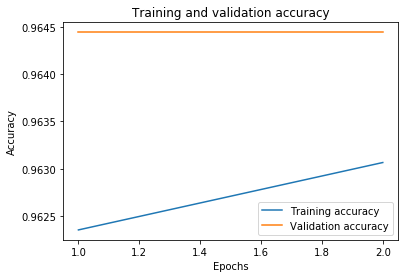

In [70]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [71]:
model.save('lstm_model1.h5')

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [92]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

def preprocessing(test, tokenizer):
    MAX_NB_WORDS = 100000    # max no. of words for tokenizer
    MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
    VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
    EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
    GLOVE_DIR = "../../Data/Toxic-Thread-Detector/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
    texts = [] 

    for line in tqdm_notebook(test, total=len(test)): 
        texts.append(clean_text(line))
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    return data

In [128]:
comments_test1 = comments_test
test_dat = preprocessing(comments_test1, tokenizer)

KeyboardInterrupt: 

In [130]:
predictions = model.predict(test_dat)

KeyboardInterrupt: 

In [113]:
len(predictions)

10000

In [139]:
comments = comments_train[12]
comments = pd.Series(comments)
comments_1 = preprocessing(comments, tokenizer)

In [140]:
prediction1 = model.predict(comments_1)

In [141]:
prediction1

array([[0.29687518, 0.10628746, 0.21644615, 0.05928646, 0.22192162,
        0.09918322]], dtype=float32)

In [135]:
comments_train[12]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [145]:
train.loc[12]

id                                                0005c987bdfc9d4b
comment_text     Hey... what is it..\n@ | talk .\nWhat is it......
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
Name: 12, dtype: object

In [146]:
comments_test[0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [147]:
comments_test[1]

'== From RfC == \n\n The title is fine as it is, IMO.'

In [148]:
comments_test[2]

'" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "'